# ML Training Data Generation with Parameter Sweeps

This notebook demonstrates how to generate synthetic training datasets for machine learning by systematically varying model parameters.

**Use cases:**
- Training neural networks for spectroscopy analysis
- Testing parameter recovery algorithms
- Exploring parameter sensitivity and identifiability
- Generating data for uncertainty quantification studies

In [1]:
import os
import numpy as np
import trspecfit
from trspecfit.utils.sweep import ParameterSweep, SweepDataset

## 1. Set Up Model

First, create your model as usual. This will be the "ground truth" model that we'll vary to generate training data.

In [2]:
# Create parent project
project = trspecfit.Project(path=os.getcwd())

# Create file instance with axes
file = trspecfit.File(
    parent_project=project,
    energy=np.arange(80, 93, 0.01),
    time=np.arange(-2, 10, 0.01)
)

In [3]:
file.reset_models()

In [4]:
# Load energy-resolved model
model_name = "Au4f" # select model name

file.load_model(model_yaml = "models_energy.yaml",
                model_info = [model_name,])
file.describe_model(model_info=model_name, detail=0)

Loading model to describe energy- (and time-)dependent data: Au4f
model name: Au4f
function: Offset from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: Shirley from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
all (1D flattened if applicable) lmfit.Parameters(): [sorted alphabetically]
Name                 Value      Min      Max   Stderr     Vary     Expr Brute_Step
GLP_01_A                20        5       25     None     True     Non

In [5]:
# Add time dependence for one or more parameters
file.add_time_dependence(model_yaml = "models_time.yaml",
                         model_info = ["ModelNone", "MonoExpNeg", "MonoExpPos"],
                         par_name = "GLP_01_x0",
                         frequency = 0.5)

Loading model to describe time-dependence of a model parameter: GLP_01_x0 of ModelNone_MonoExpNeg_MonoExpPos model


In [6]:
# Examine the model structure
file.model_active.describe()

model name: Au4f
function: Offset from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: Shirley from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
function: GLP from <module 'trspecfit.functions.energy' from '/Users/xiaoyachong/Documents/3RSE_finish/time-resolved-spectroscopy-fit/src/trspecfit/functions/energy.py'>
all (1D flattened if applicable) lmfit.Parameters(): [sorted alphabetically]
Name                        Value      Min      Max   Stderr     Vary     Expr Brute_Step
GLP_01_A                       20        5       25     None     True     None     None
GLP_01_F                        1     0.7

## 2. Define Parameter Space

Choose which parameters to vary and how. You can use:
- **Discrete ranges**: `add_range()` for specific values
- **Continuous distributions**: `add_uniform()`, `add_normal()`, `add_lognormal()`

Strategy options:
- **`'grid'`**: Full combinatorial - every combination (good for small spaces)
- **`'random'`**: Independent sampling (scalable for ML)

### Example 1: Small Grid Sweep

Good for systematic exploration of a few parameter values.

In [7]:
# Define a small grid
sweep_grid = ParameterSweep(strategy='grid', seed=42)
sweep_grid.add_range('GLP_01_x0_expFun_01_A', [-1, -0.5, -0.2, -0.1, -0.05, -0.02, -0.01, -0.005, -0.002, -0.001])
#sweep_grid.add_range('GLP_01_x0_expFun_01_tau', [10, 1, 0.1])
sweep_grid.add_range('GLP_01_x0_expFun_01_tau', [10, 5, 2, 1, 0.5, 0.2, 0.1])

print(f"Total configurations: {sweep_grid.get_n_configs()}")
print("\nFirst 5 configurations:")
for i, config in enumerate(sweep_grid):
    if i >= 5:
        break
    print(f"  Config {i}: {config}")

Total configurations: 70

First 5 configurations:
  Config 0: {'GLP_01_x0_expFun_01_A': np.float64(-1.0), 'GLP_01_x0_expFun_01_tau': np.float64(10.0)}
  Config 1: {'GLP_01_x0_expFun_01_A': np.float64(-1.0), 'GLP_01_x0_expFun_01_tau': np.float64(5.0)}
  Config 2: {'GLP_01_x0_expFun_01_A': np.float64(-1.0), 'GLP_01_x0_expFun_01_tau': np.float64(2.0)}
  Config 3: {'GLP_01_x0_expFun_01_A': np.float64(-1.0), 'GLP_01_x0_expFun_01_tau': np.float64(1.0)}
  Config 4: {'GLP_01_x0_expFun_01_A': np.float64(-1.0), 'GLP_01_x0_expFun_01_tau': np.float64(0.5)}


### Example 2: Random Sampling (Recommended for ML)

Samples parameters independently - scales to large datasets.

In [8]:
# # Define random sampling sweep
# sweep_random = ParameterSweep(strategy='random', seed=42)

# # Vary peak amplitude
# sweep_random.add_uniform('GLP_01_A', min_val=8, max_val=12, n_samples=100)

# # Vary peak position
# sweep_random.add_uniform('GLP_01_x0', min_val=8, max_val=12, n_samples=100)

# # Vary dynamics amplitude
# sweep_random.add_uniform('GLP_01_x0_expFun_01_A', min_val=0.5, max_val=5, n_samples=100)

# # Vary decay time constant
# sweep_random.add_uniform('GLP_01_x0_expFun_01_tau', min_val=10, max_val=80, n_samples=100)

# print(f"Total configurations: {sweep_random.get_n_configs()}")
# print("\nFirst 5 configurations:")
# for i, config in enumerate(sweep_random):
#     if i >= 5:
#         break
#     print(f"  Config {i}:")
#     for k, v in config.items():
#         print(f"    {k}: {v:.3f}")

## 3. Generate Training Data

Use `simulate_parameter_sweep()` to generate datasets. This:
1. Iterates through parameter configurations
2. Updates model parameters
3. Generates N noisy realizations per configuration
4. Saves everything to HDF5 file

**Memory efficiency**: Only one configuration in memory at a time!

In [9]:
# Instantiate simulator
# detection: 'analog'
#     provide noise_level (relative to signal, between 0 and 1)
#     and noise_type ('gaussian' or 'poisson' or 'none')
# detection: 'photon_counting'
#     provide counts_per_cycle (or count_rate and cycle_time)
#     noise_type is 'poisson' (default) or 'none'
# random seed for reproducibility (set to None for pseudo-random seed)
sim = trspecfit.Simulator(model=file.model_active,
                          detection='photon_counting',
                          counts_per_cycle=None,
                          seed=42
                          )

Estimating from model: 8.47e+06 counts/cycle
  (average ~5.4 counts/pixel)
For accurate simulation, specify counts_per_cycle or (count_rate, cycle_time).
This estimate assumes your model amplitudes represent realistic count rates.


### Generate Dataset

In [10]:
# Use the grid sweep (vary N_realizations for quick test vs real data generation)
sim.simulate_parameter_sweep(
    parameter_sweep=sweep_grid,
    N_realizations=70,
    filepath='ml_training_data.h5',
    show_progress=True
)

Starting parameter sweep:
  Total configurations: 70
  Realizations per config: 70
  Total datasets: 4900
  Output file: /Users/xiaoyachong/Downloads/simulatorBL931/simulated_data/ml_training_data.h5

Processing config 1/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=10}
  ✓ Saved config 1 with 70 realizations
Processing config 2/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=5}
  ✓ Saved config 2 with 70 realizations
Processing config 3/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=2}
  ✓ Saved config 3 with 70 realizations
Processing config 4/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=1}
  ✓ Saved config 4 with 70 realizations
Processing config 5/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=0.5}
  ✓ Saved config 5 with 70 realizations
Processing config 6/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=0.2}
  ✓ Saved config 6 with 70 realizations
Processing config 7/70: {GLP_01_x0_expFun_01_A=-1, GLP_01_x0_expFun_01_tau=0.1}
  ✓ Sa

## 4. Inspect Generated Data

Use `SweepDataset` to examine what was generated.

In [11]:
# Load dataset inspector
dataset = SweepDataset('simulated_data/ml_training_data.h5')
#dataset = SweepDataset('simulated_data/test_sweep.h5')

In [12]:
# Print comprehensive summary
dataset.print_summary()


Dataset: simulated_data/ml_training_data.h5
Configurations: 70
Realizations per config: 70
Total datasets: 4900

Data dimensions: 2D (time × energy)
Energy points: 1300
Time points: 1200

Detection: photon_counting
Counts per cycle: 8468392

Parameter space:
  GLP_01_x0_expFun_01_A: discrete [-1, -0.5, -0.2, -0.1, -0.05, -0.02, -0.01, -0.005, -0.002, -0.001]
  GLP_01_x0_expFun_01_tau: discrete [10, 5, 2, 1, 0.5, 0.2, 0.1]



In [13]:
# Get parameter summary as DataFrame
df = dataset.get_parameter_summary()
print("\nParameter configurations:")
display(df.round(3))

print("\nStatistical summary:")
display(df.describe().round(3))


Parameter configurations:


,GLP_01_x0_expFun_01_A,GLP_01_x0_expFun_01_tau
config_idx,,
0,-1.000,10.0
1,-1.000,5.0
2,-1.000,2.0
3,-1.000,1.0
4,-1.000,0.5
...,...,...
65,-0.001,2.0
66,-0.001,1.0
67,-0.001,0.5



Statistical summary:


,GLP_01_x0_expFun_01_A,GLP_01_x0_expFun_01_tau
count,70.000,70.000
mean,-0.189,2.686
std,0.310,3.401
min,-1.000,0.100
25%,-0.200,0.200
50%,-0.035,1.000
75%,-0.005,5.000
max,-0.001,10.000


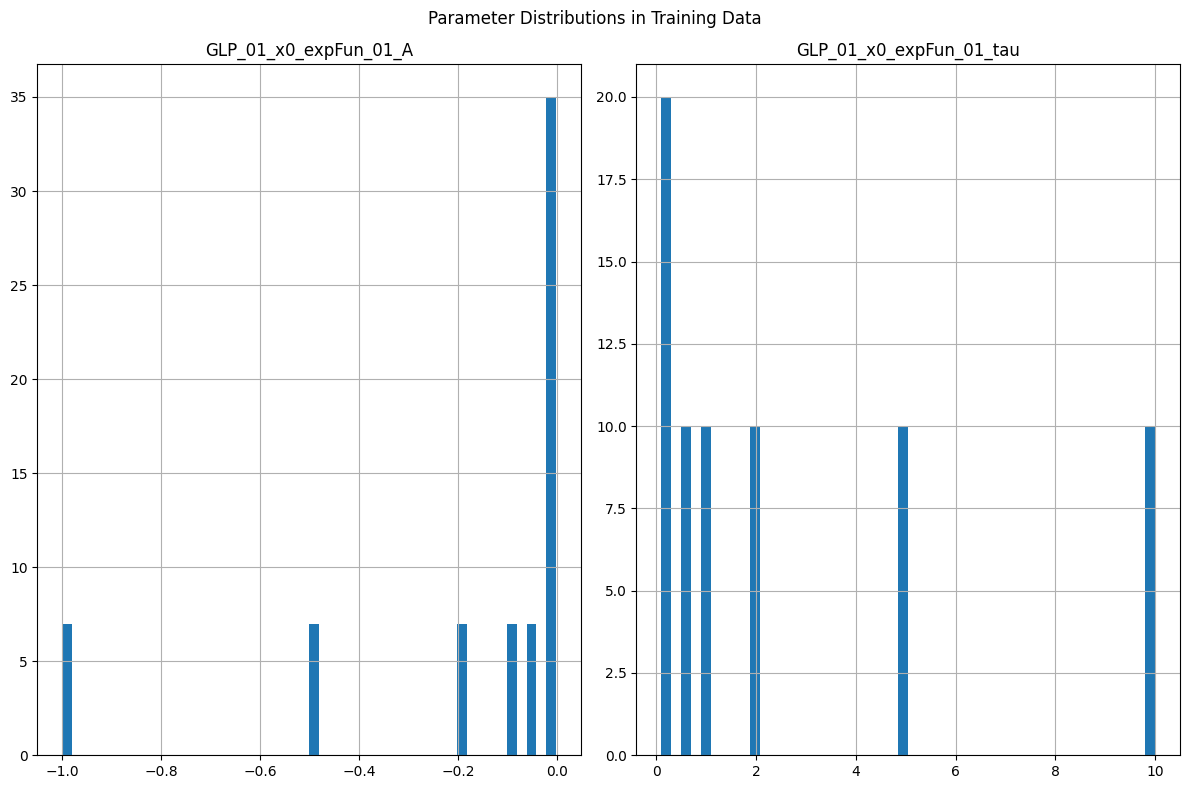

In [14]:
# Visualize parameter distributions
import matplotlib.pyplot as plt

df.hist(figsize=(12, 8), bins=50)
plt.suptitle('Parameter Distributions in Training Data')
plt.tight_layout()
plt.show()

Config 10 parameters:
  GLP_01_x0_expFun_01_A: -0.500
  GLP_01_x0_expFun_01_tau: 1.000

Data shapes:
  Clean: (1200, 1300)
  Noisy realizations: 70
  Each realization: (1200, 1300)

Visualize configuration 10:
  - Or use your own plotting with dataset.get_axes() for x/y axes
  - Or (see below): Load config, set sim.data_clean/noisy, call sim.plot_comparison(dim=2)


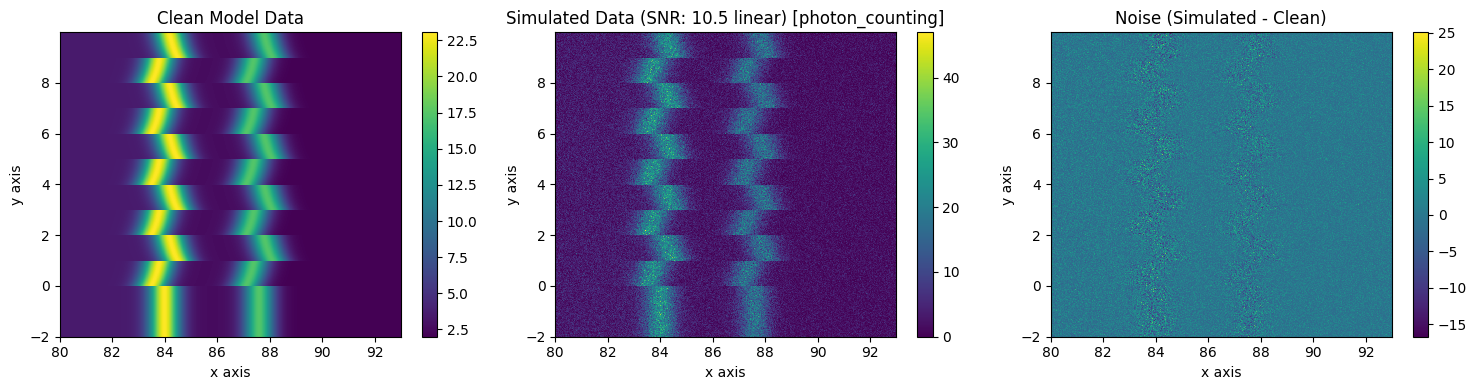

In [15]:
# Load a specific configuration for inspection
N = 10
config = dataset.load_config(N)

print(f"Config {N} parameters:")
for k, v in config['parameters'].items():
    print(f"  {k}: {v:.3f}")

print(f"\nData shapes:")
print(f"  Clean: {config['clean'].shape}")
print(f"  Noisy realizations: {len(config['noisy'])}")
print(f"  Each realization: {config['noisy'][0].shape}")

# Visualize a configuration (uses simulator's built-in plotting)
print(f"\nVisualize configuration {N}:")
print(f"  - Or use your own plotting with dataset.get_axes() for x/y axes")
print(f"  - Or (see below): Load config, set sim.data_clean/noisy, call sim.plot_comparison(dim=2)")
# Temporarily set simulator data to this config for plotting
sim.data_clean = config['clean']
sim.data_noisy = config['noisy'][0]
sim.noise = config['noisy'][0] - config['clean']
sim.plot_comparison(dim=2)

## 5. Loading Data for ML Training

For actual ML training, you'll typically write a custom data loader for your framework (PyTorch, TensorFlow, etc.). Here's a basic example using h5py directly:

In [16]:
import h5py

# Example: Load all data into memory (for small datasets)
def load_training_data(filepath, param_names):
    """
    Load parameter sweep data for ML training.
    
    Parameters
    ----------
    filepath : str
        Path to HDF5 file
    param_names : list of str
        Which parameters to extract as targets
    
    Returns
    -------
    X : list of arrays
        Input spectra (noisy realizations)
    y : list of arrays
        Target parameters for each spectrum
    """
    X = []  # Input: noisy spectra
    y = []  # Target: parameter values
    
    with h5py.File(filepath, 'r') as f:
        n_configs = f['metadata'].attrs['n_configs']
        
        for config_idx in range(n_configs):
            config_name = f'config_{config_idx:06d}'
            config_group = f['parameter_configs'][config_name]
            data_group = f['simulated_data'][config_name]
            
            # Extract target parameters
            targets = [config_group.attrs[name] for name in param_names]
            
            # Load all noisy realizations for this config
            for real_key in sorted(data_group.keys()):
                spectrum = data_group[real_key][:]
                X.append(spectrum)
                y.append(targets)
    
    return np.array(X), np.array(y)

# Example usage
X_train, y_train = load_training_data(
    'simulated_data/ml_training_data.h5',
    param_names=['GLP_01_x0_expFun_01_A', 'GLP_01_x0_expFun_01_tau']
)

print(f"Training data shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nFirst example target: {y_train[0]}")

Training data shape: (4900, 1200, 1300)
Target shape: (4900, 2)

First example target: [-1. 10.]


### Example: PyTorch Dataset Class

For large datasets that don't fit in memory:

In [20]:
# Uncomment if you have PyTorch installed:
# import torch
# from torch.utils.data import Dataset, DataLoader
# 
# class SpectroscopyDataset(Dataset):
#     """PyTorch dataset for parameter sweep data."""
#     
#     def __init__(self, filepath, param_names, transform=None):
#         self.filepath = filepath
#         self.param_names = param_names
#         self.transform = transform
#         
#         # Load metadata
#         with h5py.File(filepath, 'r') as f:
#             self.n_configs = f['metadata'].attrs['n_configs']
#             self.n_realizations = f['metadata'].attrs['n_realizations_per_config']
#         
#         self.total_samples = self.n_configs * self.n_realizations
#     
#     def __len__(self):
#         return self.total_samples
#     
#     def __getitem__(self, idx):
#         # Calculate which config and realization
#         config_idx = idx // self.n_realizations
#         real_idx = idx % self.n_realizations
#         
#         with h5py.File(self.filepath, 'r') as f:
#             config_name = f'config_{config_idx:06d}'
#             config_group = f['parameter_configs'][config_name]
#             data_group = f['simulated_data'][config_name]
#             
#             # Load spectrum
#             spectrum = data_group[f'{real_idx:06d}'][:]
#             
#             # Load target parameters
#             targets = [config_group.attrs[name] for name in self.param_names]
#         
#         if self.transform:
#             spectrum = self.transform(spectrum)
#         
#         return torch.FloatTensor(spectrum), torch.FloatTensor(targets)
# 
# # Create data loader
# dataset = SpectroscopyDataset(
#     'simulated_data/test_sweep.h5',
#     param_names=['GLP_01_x0_expFun_01_A', 'GLP_01_x0_expFun_01_tau']
# )
# 
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# 
# # Use in training loop
# for batch_spectra, batch_targets in train_loader:
#     # ... training code ...
#     pass

print("See commented code above for PyTorch example")

See commented code above for PyTorch example


## Tips for ML Training Data

**Parameter Selection:**
- Start with 2-3 most important parameters
- Use realistic ranges from your experimental data
- Include correlations if parameters are physically related

**Dataset Size:**
- Small networks: 1,000-5,000 examples often sufficient
- Larger networks: 10,000-50,000 examples
- More realizations per config = better uncertainty estimates

**Noise Level:**
- Match your experimental SNR
- Can generate multiple datasets with different noise levels
- Consider augmentation during training (add more noise)

**Validation Strategy:**
- Split by configuration, not by realization
- Test on held-out parameter ranges
- Validate on real experimental data when possible